# AML GNN on ALL datasets (cleaned AML / non-AML)

This notebook trains and evaluates a graph neural network (GNN) for AML vs non-AML classification
using **all datasets** under the current root (e.g. `E:\data\data`):

1. Discover all dataset folders that contain `json_labels/train.json` and `trained cleaned/aml`, `trained cleaned/non aml`.
2. Build per-image graphs (nodes = cells, edges = spatial k-NN) from **all AML and non-AML images** (train + test).
3. Split graphs into train/validation/test sets.
4. Train a simple GCN model and plot training/validation loss and accuracy to check for under/overfitting.
5. Evaluate on the test set and visualize confusion matrix and AML probability distributions.



In [1]:
# Cell 1: imports, configuration, and dataset discovery

# If running in a fresh environment, uncomment and run these once:
# !pip install torch torchvision torchaudio
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv
# !pip install scikit-learn matplotlib pillow

from pathlib import Path
from collections import defaultdict
import json
import random
import re

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Root that contains all dataset folders (H_*, L_*, etc.)
DATA_ROOT = Path(".")
print("Project root:", DATA_ROOT.resolve())


def discover_dataset_dirs(root: Path):
    """Find all dataset dirs that contain json_labels/train.json."""
    ds = []
    for json_dir in root.rglob("json_labels"):
        if (json_dir / "train.json").exists():
            ds.append(json_dir.parent)
    return sorted(set(ds))


dataset_dirs = discover_dataset_dirs(DATA_ROOT)
print("Found dataset dirs (used for ALL-data training):")
for d in dataset_dirs:
    print(" -", d.name, "->", d)


def infer_magnification_from_path(path: Path) -> float:
    """Infer magnification (e.g. 10, 40, 100) from a dataset path like 'H_40X_C1-...'."""
    s = str(path).replace("\\", "/")
    m = re.search(r"(\d{1,3})x", s, flags=re.IGNORECASE)
    if m:
        return float(m.group(1))
    return np.nan

# Map each dataset to a normalized magnification feature in [0, 1]
dataset_mag_raw = {ds: infer_magnification_from_path(ds) for ds in dataset_dirs}
max_mag = max(v for v in dataset_mag_raw.values() if not np.isnan(v)) if dataset_mag_raw else 1.0
json_mag_norm = {}
print("\nInferred magnifications (raw and normalized):")
for ds, v in dataset_mag_raw.items():
    norm = (v / max_mag) if not np.isnan(v) else 0.0
    print(f" - {ds.name}: raw={v}, norm={norm:.3f}")



Project root: E:\data\data
Found dataset dirs (used for ALL-data training):
 - H_100X_C1 -> H_100X_C1-20251113T062533Z-1-001\H_100X_C1
 - H_100X_C2 -> H_100X_C2-20251112T175028Z-1-001\H_100X_C2
 - H_10X_C1 -> H_10X_C1-20251113T074554Z-1-001\H_10X_C1
 - H_10X_C2 -> H_10X_C2-20251113T074051Z-1-001\H_10X_C2
 - H_40X_C1 -> H_40X_C1-20251113T072343Z-1-001\H_40X_C1
 - H_40X_C2 -> H_40X_C2-20251113T070422Z-1-001\H_40X_C2
 - L_100X_C1 -> L_100X_C1-20251113T115500Z-1-001\L_100X_C1
 - L_10X_C2 -> L_10X_C2-20251113T085811Z-1-001\L_10X_C2
 - L_40X_C1 -> L_40X_C1-20251113T085838Z-1-001\L_40X_C1
 - L_40X_C2 -> L_40X_C2-20251113T090554Z-1-001\L_40X_C2

Inferred magnifications (raw and normalized):
 - H_100X_C1: raw=100.0, norm=1.000
 - H_100X_C2: raw=100.0, norm=1.000
 - H_10X_C1: raw=10.0, norm=0.100
 - H_10X_C2: raw=10.0, norm=0.100
 - H_40X_C1: raw=40.0, norm=0.400
 - H_40X_C2: raw=40.0, norm=0.400
 - L_100X_C1: raw=100.0, norm=1.000
 - L_10X_C2: raw=10.0, norm=0.100
 - L_40X_C1: raw=40.0, norm=0.

In [3]:
# Cell 2: quick sanity check on one example dataset (first discovered)

if not dataset_dirs:
    raise RuntimeError("No dataset directories with json_labels/train.json found under DATA_ROOT.")

example_ds = dataset_dirs[0]
example_json = example_ds / "json_labels" / "train.json"
print("Example dataset:", example_ds)
print("Example train.json exists:", example_json.exists())

with example_json.open("r", encoding="utf-8") as f:
    ex_js = json.load(f)

print("Keys in example train.json:", list(ex_js.keys()))
print("# images:", len(ex_js.get("images", [])))
print("# annotations:", len(ex_js.get("annotations", [])))

if ex_js.get("images"):
    print("Example image entry:")
    print(ex_js["images"][0])
if ex_js.get("annotations"):
    print("Example annotation entry:")
    print(ex_js["annotations"][0])



Example dataset: H_100X_C1-20251113T062533Z-1-001\H_100X_C1
Example train.json exists: True
Keys in example train.json: ['info', 'licenses', 'images', 'annotations', 'categories']
# images: 7894
# annotations: 7927
Example image entry:
{'id': 0, 'width': 640, 'height': 640, 'file_name': '39_32_1000_AML.png'}
Example annotation entry:
{'id': 1, 'image_id': 0, 'category_id': 14, 'area': 10948, 'bbox': [0, 111, 68, 161], 'iscrowd': 0, 'cell_id': 4, 'category_name': 'none', 'cell_size': 4, 'nuclear_chromatio': 4, 'nuclear_shape': 4, 'nucleolus': 4, 'cytoplasm': 4, 'cytoplasmic_basophilia': 4, 'cytoplasmic_vacuoles': 4}


Using example dataset for visualization: H_100X_C1


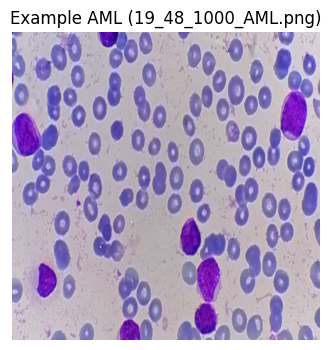

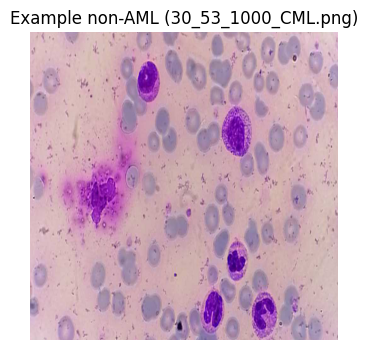

In [4]:
# Cell 3: visualize a couple of AML / non-AML images from cleaned folders

# Try to find at least one dataset with cleaned folders
sample_aml, sample_nonaml = None, None
for ds in dataset_dirs:
    aml_dir = ds / "trained cleaned" / "aml"
    nonaml_dir = ds / "trained cleaned" / "non aml"
    if aml_dir.exists() and nonaml_dir.exists():
        aml_imgs = sorted(aml_dir.glob("*.png"))
        nonaml_imgs = sorted(nonaml_dir.glob("*.png"))
        if aml_imgs and nonaml_imgs:
            sample_aml = random.choice(aml_imgs)
            sample_nonaml = random.choice(nonaml_imgs)
            print("Using example dataset for visualization:", ds.name)
            break


def show_example(img_path: Path, title: str):
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

if sample_aml is not None and sample_nonaml is not None:
    show_example(sample_aml, f"Example AML ({sample_aml.name})")
    show_example(sample_nonaml, f"Example non-AML ({sample_nonaml.name})")
else:
    print("No cleaned AML/non-AML folders with images found. Make sure sort_all_train_aml.py has been run.")



In [ ]:
# Cell 4: build graphs from ALL datasets using cleaned AML/non-AML folders

from sklearn.metrics.pairwise import euclidean_distances

# Collect all category labels and morphology features across ALL selected images
all_cat, all_num = [], []
# List of (json_path, img_id, label)
graph_specs = []


def safe_float(v):
    """Convert value to float, returning NaN if it is non-numeric (e.g. 'l')."""
    try:
        return float(v)
    except (TypeError, ValueError):
        return np.nan


def collect_ids_from_folder(folder: Path, name_to_id):
    ids, not_found = [], []
    for p in folder.glob("*.png"):
        img_id = name_to_id.get(p.name)
        if img_id is None:
            not_found.append(p.name)
        else:
            ids.append(int(img_id))
    return sorted(set(ids)), not_found


for ds in dataset_dirs:
    aml_dir = ds / "trained cleaned" / "aml"
    nonaml_dir = ds / "trained cleaned" / "non aml"
    if not (aml_dir.exists() and nonaml_dir.exists()):
        print("[skip]", ds, "missing 'trained cleaned/aml' or 'trained cleaned/non aml'")
        continue

    mag_raw = dataset_mag_raw.get(ds, np.nan)
    mag_norm = (mag_raw / max_mag) if not np.isnan(mag_raw) else 0.0

    for split in ("train", "test"):
        json_path = ds / "json_labels" / f"{split}.json"
        if not json_path.exists():
            continue
        # Remember normalized magnification for this JSON file
        json_mag_norm[json_path] = mag_norm

        with json_path.open("r", encoding="utf-8") as f:
            js = json.load(f)
        images = js.get("images", [])
        annotations = js.get("annotations", [])
        name_to_id = {img["file_name"]: img["id"] for img in images}

        ann_by_image = defaultdict(list)
        for ann in annotations:
            ann_by_image[ann["image_id"]].append(ann)

        aml_ids, aml_nf = collect_ids_from_folder(aml_dir, name_to_id)
        nonaml_ids, non_nf = collect_ids_from_folder(nonaml_dir, name_to_id)

        if aml_ids or nonaml_ids:
            print(f"{ds.name} [{split}]: AML={len(aml_ids)}, non-AML={len(nonaml_ids)}, "
                  f"aml_not_found={len(aml_nf)}, nonaml_not_found={len(non_nf)})")

        # For encoder fitting
        for img_id in aml_ids + nonaml_ids:
            for a in ann_by_image.get(img_id, []):
                all_cat.append(a.get("category_name", "unknown"))
                nf = [
                    safe_float(a.get("cell_size", np.nan)),
                    safe_float(a.get("nuclear_chromatio", np.nan)),
                    safe_float(a.get("nuclear_shape", np.nan)),
                    safe_float(a.get("nucleolus", np.nan)),
                    safe_float(a.get("cytoplasm", np.nan)),
                    safe_float(a.get("cytoplasmic_basophilia", np.nan)),
                    safe_float(a.get("cytoplasmic_vacuoles", np.nan)),
                ]
                all_num.append(nf)

        for img_id in aml_ids:
            graph_specs.append((json_path, int(img_id), 1))
        for img_id in nonaml_ids:
            graph_specs.append((json_path, int(img_id), 0))

print("Total selected image graphs across all datasets:", len(graph_specs))

# Fit encoders on all collected nodes
all_cat_unique = sorted(set(all_cat)) or ["unknown"]
try:
    oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
except TypeError:
    oh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
oh_encoder.fit(np.array(all_cat_unique).reshape(-1, 1))

all_num_arr = np.array(all_num, float)
sentinel = 4.0
all_num_arr[all_num_arr == sentinel] = np.nan
col_meds = np.nanmedian(all_num_arr, axis=0)
inds = np.where(np.isnan(all_num_arr))
for r, c in zip(*inds):
    all_num_arr[r, c] = col_meds[c] if not np.isnan(col_meds[c]) else 0.0

scaler = StandardScaler()
scaler.fit(all_num_arr)

USE_KNN = True
K_KNN = 8
EPS = 1e-8


def build_nodes_and_features(anns, width: float, height: float):
    """Compute NORMALIZED cell centers and raw morphology features.

    Centers are divided by image width/height so that coordinates lie in [0, 1]
    regardless of magnification or pixel resolution.
    """
    coords, cats, num_feats = [], [], []
    w_img = max(width, 1.0)
    h_img = max(height, 1.0)
    for ann in anns:
        x, y, w, h = ann["bbox"]
        cx = (x + w / 2.0) / w_img
        cy = (y + h / 2.0) / h_img
        coords.append([cx, cy])
        cats.append([ann.get("category_name", "unknown")])
        # Use safe_float here as well to guard against string values like 'l'
        nf = [
            safe_float(ann.get("cell_size", np.nan)),
            safe_float(ann.get("nuclear_chromatio", np.nan)),
            safe_float(ann.get("nuclear_shape", np.nan)),
            safe_float(ann.get("nucleolus", np.nan)),
            safe_float(ann.get("cytoplasm", np.nan)),
            safe_float(ann.get("cytoplasmic_basophilia", np.nan)),
            safe_float(ann.get("cytoplasmic_vacuoles", np.nan)),
        ]
        num_feats.append(nf)
    return np.array(coords, float), np.array(cats), np.array(num_feats, float)


def build_json_maps(json_path: Path):
    with json_path.open("r", encoding="utf-8") as f:
        js = json.load(f)
    images = js.get("images", [])
    annotations = js.get("annotations", [])
    id_to_image = {img["id"]: img for img in images}
    ann_by_image = defaultdict(list)
    for ann in annotations:
        ann_by_image[ann["image_id"]].append(ann)
    return id_to_image, ann_by_image


# Cache JSON maps
json_cache = {}
for json_path, img_id, label in graph_specs:
    if json_path not in json_cache:
        json_cache[json_path] = build_json_maps(json_path)


def build_graph_for_image(json_path: Path, img_id: int, label: int):
    id_to_image, ann_by_image = json_cache[json_path]
    anns = ann_by_image.get(img_id, [])
    if not anns:
        return None

    img_meta = id_to_image[img_id]
    width = float(img_meta.get("width", 1.0) or 1.0)
    height = float(img_meta.get("height", 1.0) or 1.0)

    coords, cats, num_feats = build_nodes_and_features(anns, width=width, height=height)

    num_feats[num_feats == sentinel] = np.nan
    for col in range(num_feats.shape[1]):
        mask = np.isnan(num_feats[:, col])
        if mask.any():
            num_feats[mask, col] = col_meds[col]
    num_feats_scaled = scaler.transform(num_feats)

    cat_oh = oh_encoder.transform(cats)

    # Append normalized magnification as an extra feature channel for each node
    mag_feature = json_mag_norm.get(json_path, 0.0)
    mag_col = np.full((cats.shape[0], 1), mag_feature, dtype=np.float32)

    x = np.hstack([cat_oh, num_feats_scaled, mag_col]).astype(np.float32)

    n = coords.shape[0]
    dists = euclidean_distances(coords, coords)
    edge_index, edge_attr = [], []

    if USE_KNN:
        k = min(K_KNN, max(1, n - 1))
        for i in range(n):
            order = np.argsort(dists[i])
            nbrs = order[1 : k + 1]
            for j in nbrs:
                if i == j:
                    continue
                w = 1.0 / (dists[i, j] + EPS)
                mult = 1.0 if anns[i].get("category_name") == anns[j].get("category_name") else 0.5
                w *= mult
                edge_index.append([i, j])
                edge_attr.append([w])
                edge_index.append([j, i])
                edge_attr.append([w])
    else:
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                w = 1.0 / (dists[i, j] + EPS)
                mult = 1.0 if anns[i].get("category_name") == anns[j].get("category_name") else 0.5
                w *= mult
                edge_index.append([i, j])
                edge_attr.append([w])

    if edge_index:
        edge_index_t = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr_t = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index_t = torch.empty((2, 0), dtype=torch.long)
        edge_attr_t = torch.empty((0, 1), dtype=torch.float)

    y = torch.tensor([label], dtype=torch.long)
    file_name = id_to_image[img_id]["file_name"]

    data = Data(
        x=torch.tensor(x),
        edge_index=edge_index_t,
        edge_attr=edge_attr_t,
        y=y,
    )
    data.img_id = int(img_id)
    data.file_name = file_name
    return data


graphs = []
for json_path, img_id, label in graph_specs:
    g = build_graph_for_image(json_path, img_id, label)
    if g is not None:
        graphs.append(g)

print("Total graphs built from all datasets:", len(graphs))
if graphs:
    print("Input feature dim:", graphs[0].x.shape[1])



H_100X_C1 [train]: AML=767, non-AML=909, aml_not_found=269, nonaml_not_found=423)
H_100X_C1 [test]: AML=269, non-AML=423, aml_not_found=767, nonaml_not_found=909)
H_100X_C2 [train]: AML=767, non-AML=910, aml_not_found=269, nonaml_not_found=423)
H_100X_C2 [test]: AML=269, non-AML=423, aml_not_found=767, nonaml_not_found=910)
H_10X_C1 [train]: AML=735, non-AML=873, aml_not_found=260, nonaml_not_found=397)
H_10X_C1 [test]: AML=260, non-AML=397, aml_not_found=735, nonaml_not_found=873)
H_10X_C2 [train]: AML=767, non-AML=910, aml_not_found=269, nonaml_not_found=423)
H_10X_C2 [test]: AML=269, non-AML=423, aml_not_found=767, nonaml_not_found=910)
H_40X_C1 [train]: AML=750, non-AML=889, aml_not_found=262, nonaml_not_found=414)
H_40X_C1 [test]: AML=262, non-AML=414, aml_not_found=750, nonaml_not_found=889)
H_40X_C2 [train]: AML=760, non-AML=907, aml_not_found=263, nonaml_not_found=419)
H_40X_C2 [test]: AML=263, non-AML=419, aml_not_found=760, nonaml_not_found=907)
L_100X_C1 [train]: AML=765, no

In [ ]:
# Cell 5: train/validation/test split and DataLoaders

import random as _random

_random.shuffle(graphs)
num_total = len(graphs)

n_train = int(0.7 * num_total)
n_val = int(0.15 * num_total)

train_graphs = graphs[:n_train]
val_graphs = graphs[n_train : n_train + n_val]
test_graphs = graphs[n_train + n_val :]

print(f"Train graphs: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)



In [ ]:
# Cell 6: define 1-layer GNN model, train, and plot train/val curves

class AMLGCN(nn.Module):
    """1-layer GCN + MLP head."""
    def __init__(self, in_channels: int, hidden_channels: int = 64, num_classes: int = 2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, data: Data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not graphs:
    raise RuntimeError("No graphs were built. Check previous cells for errors.")

in_channels = graphs[0].x.shape[1]
model = AMLGCN(in_channels=in_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


def run_epoch(loader: DataLoader, train: bool = False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device)
        if train:
            optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        preds = out.argmax(dim=-1)
        correct += int((preds == batch.y.view(-1)).sum().item())
        total += batch.num_graphs
    return total_loss / max(total, 1), correct / max(total, 1)


num_epochs = 30
best_val_acc = 0.0
best_state = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model state with val_acc={best_val_acc:.4f}")

# Plot training vs validation loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(range(1, num_epochs + 1), train_losses, label="Train loss")
axes[0].plot(range(1, num_epochs + 1), val_losses, label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].legend()

axes[1].plot(range(1, num_epochs + 1), train_accs, label="Train acc")
axes[1].plot(range(1, num_epochs + 1), val_accs, label="Val acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Epoch")
axes[1].legend()

plt.tight_layout()

# Save model
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODELS_DIR / "gnn_aml_all_data.pt"
torch.save({"model_state": model.state_dict(), "in_channels": in_channels}, model_path)
print("Saved ALL-data trained model to", model_path)



In [ ]:
# Cell 7: evaluate on test set and visualize results

model.eval()
all_true, all_pred, all_prob = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        probs = F.softmax(out, dim=-1)[:, 1].cpu().numpy()
        preds = out.argmax(dim=-1).cpu().numpy()
        ys = batch.y.view(-1).cpu().numpy()
        all_true.extend(list(ys))
        all_pred.extend(list(preds))
        all_prob.extend(list(probs))

all_true_arr = np.array(all_true)
all_pred_arr = np.array(all_pred)

print("Classification report (0=non-AML, 1=AML):")
print(classification_report(all_true_arr, all_pred_arr, digits=4))

cm = confusion_matrix(all_true_arr, all_pred_arr)
print("Confusion matrix:")
print(cm)

RESULTS_DIR = Path("notebook_outputs_all_data")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Confusion matrix heatmap
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
im = ax_cm.imshow(cm, cmap="Blues")
ax_cm.set_title("Confusion Matrix (Test)")
ax_cm.set_xlabel("Predicted label")
ax_cm.set_ylabel("True label")
ax_cm.set_xticks([0, 1])
ax_cm.set_yticks([0, 1])
ax_cm.set_xticklabels(["non-AML", "AML"])
ax_cm.set_yticklabels(["non-AML", "AML"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax_cm.text(j, i, cm[i, j], ha="center", va="center", color="black")

fig_cm.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
fig_cm.tight_layout()
cm_path = RESULTS_DIR / "confusion_matrix.png"
fig_cm.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

# Correct vs incorrect bar chart
correct_mask = all_true_arr == all_pred_arr
num_correct = int(correct_mask.sum())
num_incorrect = int(len(all_true_arr) - num_correct)

fig_ci, ax_ci = plt.subplots(figsize=(4, 4))
ax_ci.bar(["Correct", "Incorrect"], [num_correct, num_incorrect], color=["#16a34a", "#dc2626"])
ax_ci.set_ylabel("Number of graphs")
ax_ci.set_title("Correct vs Incorrect Predictions (Test)")
for i, v in enumerate([num_correct, num_incorrect]):
    ax_ci.text(i, v + 0.5, str(v), ha="center", va="bottom")

fig_ci.tight_layout()
ci_path = RESULTS_DIR / "correct_incorrect.png"
fig_ci.savefig(ci_path, dpi=150, bbox_inches="tight")
plt.show()

# AML probability histograms by true class
fig_prob, ax_prob = plt.subplots(figsize=(5, 3))
ax_prob.hist([p for t, p in zip(all_true_arr, all_prob) if t == 0], bins=20, alpha=0.6, label="non-AML")
ax_prob.hist([p for t, p in zip(all_true_arr, all_prob) if t == 1], bins=20, alpha=0.6, label="AML")
ax_prob.set_xlabel("Predicted AML probability")
ax_prob.set_ylabel("Count")
ax_prob.legend()
ax_prob.set_title("Test-set AML probability distributions (ALL data)")
fig_prob.tight_layout()
prob_path = RESULTS_DIR / "probability_histograms.png"
fig_prob.savefig(prob_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved confusion matrix to", cm_path)
print("Saved correct/incorrect plot to", ci_path)
print("Saved probability histograms to", prob_path)

